In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def load_and_preprocess_data(train_path, test_path):
    # Load data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # Drop unnecessary columns and set index
    if 'Unnamed: 0' in train_df.columns:
        train_df.drop('Unnamed: 0', axis=1, inplace=True)
    if 'Unnamed: 0' in test_df.columns:
        test_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    train_df.set_index('id', inplace=True)
    test_df.set_index('id', inplace=True)

    for df in [train_df, test_df]:
        for col in ['host_response_rate', 'host_acceptance_rate']:
            if col in df.columns:
                df[col] = df[col].str.replace('%', '').astype(float)  # Convert to numeric
    
    return train_df, test_df

def extract_features_from_name(df):
    # Extract features from name column
    def extract_rating(parts):
        for part in parts:
            if '★' in part:
                try:
                    return float(part.replace('★', '').strip())
                except ValueError:
                    continue
        return 0

    def is_property_new(parts):
        for part in parts:
            if 'new' in part.lower():
                return 1
        return 0

    def extract_bedrooms(parts):
        for part in parts:
            if 'Studio' in part:
                return 0
            elif 'bedroom' in part:
                try:
                    return int(part.split()[0])
                except ValueError:
                    continue
        return 0

    def extract_beds(parts):
        for part in parts:
            if 'bed' in part:
                try:
                    return int(part.split()[0])
                except ValueError:
                    continue
        return 0

    def extract_baths(parts):
        for part in parts:
            if 'half-bath' in part.lower():
                return 0.5
            if 'bath' in part.lower():
                try:
                    return float(part.split()[0])
                except ValueError:
                    continue
        return 0

    def is_private_bath(parts):
        for part in parts:
            if 'private' in part.lower() and 'bath' in part.lower():
                return 1
        return 0

    def is_shared_bath(parts):
        for part in parts:
            if 'shared' in part.lower() and 'bath' in part.lower():
                return 1
        return 0

    df["split_parts"] = df["name"].str.split("·")
    df["bedrooms"] = df["split_parts"].apply(extract_bedrooms)
    df["beds"] = df["split_parts"].apply(extract_beds)
    df["baths"] = df["split_parts"].apply(extract_baths)
    df["is_bath_private"] = df["split_parts"].apply(is_private_bath).astype(int)
    df["is_bath_shared"] = df["split_parts"].apply(is_shared_bath).astype(int)
    df["overall_rating"] = df["split_parts"].apply(extract_rating)
    df["is_new_property"] = df["split_parts"].apply(is_property_new).astype(int)
    
    df.drop('split_parts', axis=1, inplace=True)
    return df

def process_neighborhood_overview(df, tfidf_vectorizer=None):
    def clean_text(text):
        if pd.isna(text):
            return ''
        text = BeautifulSoup(text, "html.parser").get_text()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['cleaned_neighborhood_overview'] = df['neighborhood_overview'].apply(clean_text)
    df['cleaned_neighborhood_overview'].fillna('no description available', inplace=True)
    
    if tfidf_vectorizer is None:
        tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
        tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_neighborhood_overview'])
    else:
        tfidf_matrix = tfidf_vectorizer.transform(df['cleaned_neighborhood_overview'])
    
    # Convert to DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), 
                           columns=[f'tfidf_{i}' for i in range(100)],
                           index=df.index)
    
    return pd.concat([df, tfidf_df], axis=1), tfidf_vectorizer

def create_feature_engineering(df):
    # Clean price column
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
    
    # Create revenue features
    df['minimum_monthly_revenue'] = df['minimum_nights'] * df['price']
    df['maximum_monthly_revenue'] = df['maximum_nights'] * df['price']
    
    # Create availability ratios
    availability_days = [30, 60, 90, 365]
    for days in availability_days:
        # Compute availability ratio
        df[f'availability_ratio_{days}'] = df[f'availability_{days}'] / days
        # Compute monthly revenue
        factor = 30 if days != 30 else 1
        df[f'monthly_revenue_{days}'] = df[f'availability_ratio_{days}'] * df['price'] * factor
    
    return df

def prepare_features(df):
    # Columns to drop
    cols_to_drop = ['host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 
                    'amenities', 'name', 'neighborhood_overview', 'cleaned_neighborhood_overview']
    
    # Categorical columns for one-hot encoding
    categorical_features = ['host_response_time', 'neighbourhood_cleansed', 
                          'property_type', 'room_type', 'host_is_superhost']
    
    # Numerical columns for scaling
    numerical_features = ['host_response_rate', 'host_acceptance_rate', 
                         'host_listings_count', 'host_total_listings_count',
                         'accommodates', 'beds', 'minimum_nights', 'maximum_nights',
                         'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                         'number_of_reviews', 'number_of_reviews_ltm',
                         'review_scores_rating', 'review_scores_accuracy',
                         'review_scores_cleanliness', 'review_scores_checkin',
                         'review_scores_communication', 'review_scores_location',
                         'review_scores_value', 'calculated_host_listings_count',
                         'reviews_per_month', 'minimum_monthly_revenue',
                         'maximum_monthly_revenue']
    
    # Add availability ratios and monthly revenue columns
    for days in [30, 60, 90, 365]:
        numerical_features.extend([f'availability_ratio_{days}', f'monthly_revenue_{days}'])
    
    # Add engineered features from name
    numerical_features.extend(['bedrooms', 'baths', 'overall_rating'])
    categorical_features.extend(['is_bath_private', 'is_bath_shared', 'is_new_property'])
    
    # Add TF-IDF features
    tfidf_features = [col for col in df.columns if col.startswith('tfidf_')]
    numerical_features.extend(tfidf_features)
    
    # Drop specified columns
    df = df.drop(cols_to_drop, axis=1)
    
    return df, numerical_features, categorical_features

def create_model_pipeline(numerical_features, categorical_features):
    # Create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessors
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define parameter distributions for each model
    param_distributions = {
        'RandomForest': {
            'regressor__n_estimators': randint(100, 500),
            'regressor__max_depth': [None] + list(range(10, 50, 5)),
            'regressor__min_samples_split': randint(2, 20),
            'regressor__min_samples_leaf': randint(1, 10),
            'regressor__max_features': ['sqrt', 'log2', None]
        },
        'GradientBoosting': {
            'regressor__n_estimators': randint(100, 500),
            'regressor__learning_rate': uniform(0.01, 0.3),
            'regressor__max_depth': randint(3, 10),
            'regressor__min_samples_split': randint(2, 20),
            'regressor__min_samples_leaf': randint(1, 10),
            'regressor__subsample': uniform(0.6, 0.4)
        },
        'XGBoost': {
            'regressor__n_estimators': randint(100, 500),
            'regressor__learning_rate': uniform(0.01, 0.3),
            'regressor__max_depth': randint(3, 15),  # Deeper exploration
            'regressor__min_child_weight': randint(1, 10),
            'regressor__subsample': uniform(0.5, 0.5),  # Wider range
            'regressor__colsample_bytree': uniform(0.5, 0.5)  # Wider range
        },
        'ElasticNet': {
            'regressor__alpha': uniform(0.0001, 1.0),
            'regressor__l1_ratio': uniform(0, 1),
            'regressor__max_iter': [2000]
        }
    }

    # Create base model pipelines
    base_models = {
        'RandomForest': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42))
        ]),
        'GradientBoosting': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(random_state=42))
        ]),
        'XGBoost': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', xgb.XGBRegressor(random_state=42))
        ]),
        'ElasticNet': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', ElasticNet(random_state=42))
        ])
    }

    # Create RandomizedSearchCV for each model
    models = {}
    for name, pipeline in base_models.items():
        models[name] = RandomizedSearchCV(
            pipeline,
            param_distributions=param_distributions[name],
            n_iter=20,  # Number of parameter settings sampled
            cv=3,       # Number of cross-validation folds
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,  # Use all available cores
            random_state=42,
            verbose=1
        )

    return models

def evaluate_models_and_create_submissions(models, X_train, y_train, X_test, test_df):
    results = {}
    best_params = {}
    
    # Split training data for evaluation
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    for name, model in models.items():
        print(f"\nTraining {name} with RandomizedSearchCV...")
        
        # Fit model with randomized search
        model.fit(X_train_split, y_train_split)
        
        # Store best parameters
        best_params[name] = model.best_params_
        print(f"\nBest parameters for {name}:")
        for param, value in model.best_params_.items():
            print(f"{param}: {value}")
        
        # Make predictions using best model
        train_pred = model.predict(X_train_split)
        val_pred = model.predict(X_val)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train_split, train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        train_r2 = r2_score(y_train_split, train_pred)
        val_r2 = r2_score(y_val, val_pred)
        
        # Store results
        results[name] = {
            'Train RMSE': train_rmse,
            'Validation RMSE': val_rmse,
            'Train R2': train_r2,
            'Validation R2': val_r2,
            'Best CV Score': -model.best_score_  # Convert back from negative RMSE
        }
        
        # Create submission file
        print(f"Creating submission for {name}...")
        
        # Retrain best model on full training data
        model.best_estimator_.fit(X_train, y_train)
        
        # Predict on test data
        test_predictions = model.best_estimator_.predict(X_test)
        
        # Create submission DataFrame
        submission = pd.DataFrame({
            'id': test_df.index,
            'monthly_revenue': test_predictions
        })
        
        # Save submission
        submission.to_csv(f'submission_{name.lower()}_tuned.csv', index=False)
        print(f"Saved submission_{name.lower()}_tuned.csv")
    
    return results, best_params

def analyze_xgboost_feature_importance(model, X_train):
    """
    Analyze and print feature importance from XGBoost, adjusted for transformed feature names.
    """
    print("\nAnalyzing XGBoost feature importance...")
    
    # Extract the best estimator from RandomizedSearchCV
    best_model = model.best_estimator_

    # Extract the preprocessor and regressor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    regressor = best_model.named_steps['regressor']

    if hasattr(regressor, 'feature_importances_'):
        # Fit the preprocessor on the training data to ensure all transformers are applied
        preprocessor.fit(X_train)

        importances = regressor.feature_importances_

        # Get the feature names from the ColumnTransformer
        feature_names = []
        if hasattr(preprocessor, 'transformers'):
            for transformer_name, transformer_obj, columns in preprocessor.transformers:
                if isinstance(transformer_obj, Pipeline):  # If the transformer is a pipeline (e.g., for scaling)
                    # Check if there's a 'scaler' step in the pipeline
                    sub_transformer = transformer_obj.named_steps.get('scaler', None)
                    if sub_transformer and hasattr(sub_transformer, 'get_feature_names_out'):
                        # Add the feature names from the scaled columns
                        feature_names.extend(sub_transformer.get_feature_names_out(columns))
                elif transformer_obj is not None:  # Handle other transformers like simple imputation
                    feature_names.extend(columns)
        
        # Ensure the length of feature names matches the importances
        if len(importances) == len(feature_names):
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)

            print("\nTop 10 Important Features:")
            print(importance_df.head(10))
        else:
            print(f"Feature names length ({len(feature_names)}) does not match importances length ({len(importances)})")
    else:
        print("Feature importances are not available for this model.")


In [50]:
selected_model = "XGBoost"
    # Load data
train_df, test_df = load_and_preprocess_data('../input/train.csv', '../input/test.csv')

# Process name column
print("Processing name column...")
train_df = extract_features_from_name(train_df)
test_df = extract_features_from_name(test_df)

# Process neighborhood overview
print("Processing neighborhood overview...")
train_df, tfidf_vectorizer = process_neighborhood_overview(train_df)
test_df, _ = process_neighborhood_overview(test_df, tfidf_vectorizer)

# Create engineered features
print("Creating engineered features...")
train_df = create_feature_engineering(train_df)
test_df = create_feature_engineering(test_df)

# Prepare features
print("Preparing features...")
train_df, numerical_features, categorical_features = prepare_features(train_df)
test_df, _, _ = prepare_features(test_df)

# Split features and target
X_train = train_df.drop('monthly_revenue', axis=1)
y_train = train_df['monthly_revenue']
X_test = test_df

print("Creating model pipelines with RandomizedSearchCV...")
models = create_model_pipeline(numerical_features, categorical_features)

# Filter for the selected model
if selected_model:
    if isinstance(selected_model, list):  # If multiple models are provided
        models = {name: model for name, model in models.items() if name in selected_model}
    else:
        models = {selected_model: models[selected_model]}


# Evaluate models and create submissions
results, best_params = evaluate_models_and_create_submissions(
    models, X_train, y_train, X_test, test_df
)

# Print results
print("\nFinal Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    print("\nBest Parameters:")
    for param, value in best_params[model_name].items():
        print(f"{param}: {value}")

# if 'XGBoost' in models:
#     analyze_xgboost_feature_importance(models['XGBoost'], X_train)

Processing name column...
Processing neighborhood overview...
Creating engineered features...
Preparing features...
Creating model pipelines with RandomizedSearchCV...

Training XGBoost with RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for XGBoost:
regressor__colsample_bytree: 0.8540362888980227
regressor__learning_rate: 0.016175348288740735
regressor__max_depth: 4
regressor__min_child_weight: 8
regressor__n_estimators: 393
regressor__subsample: 0.5003893829205072
Creating submission for XGBoost...
Saved submission_xgboost_tuned.csv

Final Results:

XGBoost:
Train RMSE: 1005.2362
Validation RMSE: 1102.4501
Train R2: 0.4446
Validation R2: 0.2515
Best CV Score: 1136.9646

Best Parameters:
regressor__colsample_bytree: 0.8540362888980227
regressor__learning_rate: 0.016175348288740735
regressor__max_depth: 4
regressor__min_child_weight: 8
regressor__n_estimators: 393
regressor__subsample: 0.5003893829205072


In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you already have numerical_features and categorical_features
def get_feature_names_from_transformer(preprocessor, numerical_features, categorical_features):
    # Extract feature names after transformation
    numeric_transformer = preprocessor.transformers_[0][1]  # First transformer for numerical features
    categorical_transformer = preprocessor.transformers_[1][1]  # Second transformer for categorical features
    
    # Get names of numerical features after scaling
    numerical_feature_names = numerical_features  # No change in the names for numerical features
    
    # Get names of categorical features after one-hot encoding
    categorical_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
    
    # Get names of TF-IDF features (from the vectorizer)
    tfidf_feature_names = preprocessor.transformers_[-1][1].named_steps['vectorizer'].get_feature_names_out()
    
    # Combine all feature names
    all_feature_names = list(numerical_feature_names) + list(categorical_feature_names) + list(tfidf_feature_names)
    
    return all_feature_names


# Assuming the model is already fitted
xgb_model = models['XGBoost'].best_estimator_

# Extract feature importance from XGBoost model
importance = xgb_model.named_steps['regressor'].get_booster().get_score(importance_type='weight')

# Get feature names from the preprocessor pipeline
all_feature_names = get_feature_names_from_transformer(preprocessor, numerical_features, categorical_features)

# Map the importance values to feature names
importance_df = pd.DataFrame({
    'Feature': [all_feature_names[int(key[1:])] if key.startswith('f') else key for key in importance.keys()],
    'Importance': importance.values()
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.show()


AttributeError: 'str' object has no attribute 'named_steps'

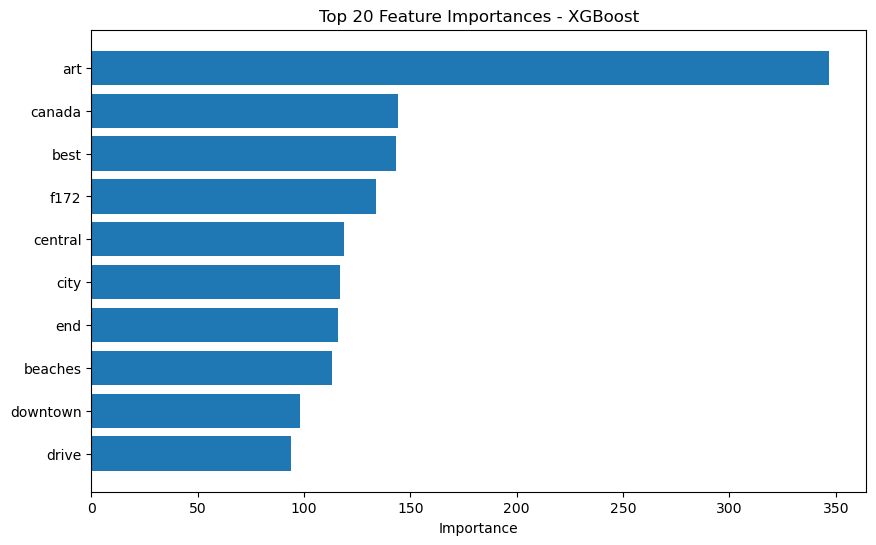

In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()
# Extract feature importance from XGBoost model
importance = xgb_model.named_steps['regressor'].get_booster().get_score(importance_type='weight')

# Map feature names to actual terms
feature_names_map = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': [feature_names_map.get(key, key) for key in importance.keys()],
    'Importance': importance.values()
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.show()
